In [286]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [287]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [288]:
from time import sleep
from random import uniform
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support import expected_conditions as EC

PATH = "/Users/vicky/Desktop/chromedriver"
driver = webdriver.Chrome(PATH)
driver.get("localhost:8080")

Frame = WebDriverWait(driver, 10).until(
        #EC.presence_of_element_located((By.XPATH,'//*[@id="root"]/div/div/div/div/ul/li'))
        EC.presence_of_element_located((By.CLASS_NAME,'App'))
        )


pngimg = Frame.screenshot_as_png
f = open('/Users/vicky/Desktop/file2.png', 'wb')
f.write(pngimg)
f.close()

#driver.quit()

In [289]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [290]:
#my_img = cv2.imread('/Users/vicky/Desktop/file2.png')
#plt.imshow(my_img)

In [291]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [292]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/Users/vicky/Desktop/Tensorflow object detection api tutorial/models-master/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [293]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [294]:
import cv2
image = cv2.imread("/Users/vicky/Desktop/file2.png")

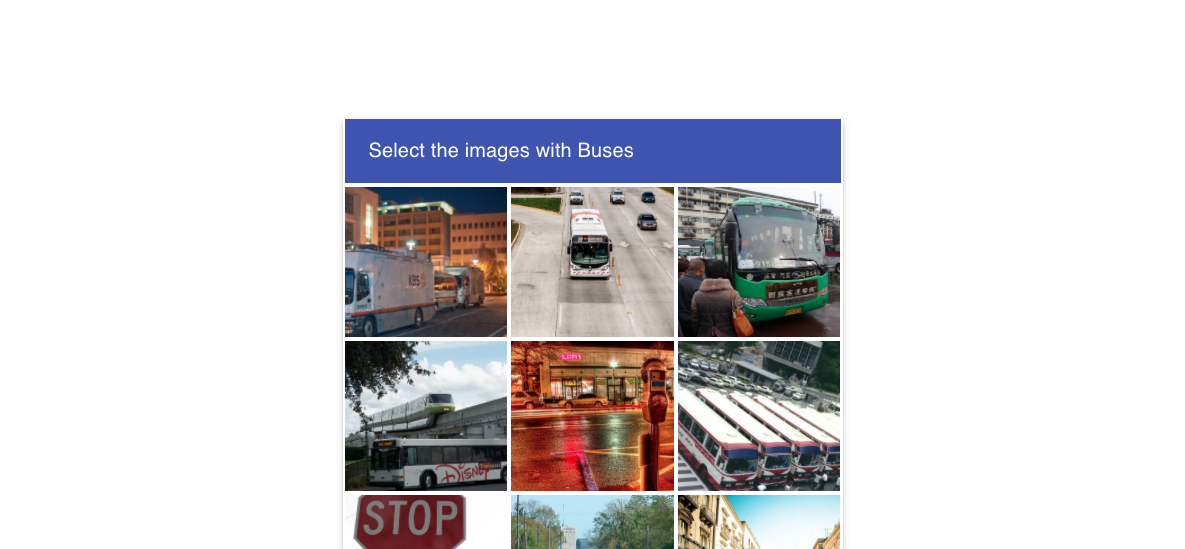

In [295]:
def run_inference_for_single_image(model,image):
  image = np.array(image)
  
  input_tensor = tf.convert_to_tensor(image)
  
  input_tensor = input_tensor[tf.newaxis,...]

  
  output_dict = model(input_tensor)


  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 1,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

def show_inference(model,image):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = image
  image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
  # Actual detection.
  output_dict = run_inference_for_single_image(model,image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))
    
show_inference(detection_model,image)

driver.close()


